In [1]:
# Load all methods
%run 10_a_preprocess_non_interactive.ipynb

In [2]:
# Write status to log file without date time stampe
path = output_path
msg = 'Import libraries completed'
file_name = '2_model_random_forest_results_'+'.log'
log_to_file(path,msg,file_name)

In [3]:
# Define data and target
df =  'df_processed_final.csv'    #'fd.csv' 
target ='Survived'  # 'fd_taken' 
path = output_path_csvs

# Load data
df = read_file(df,path) 

In [4]:
# test point
df.head(2)

Survived  Pclass   Age  SibSp  Parch       Fare  Sex_male  Embarked_Q  \
0         0     3.0  22.0    0.0    0.0  31.815983         1           0   
1         1     3.0  22.0    0.0    0.0  31.815983         1           0   

   Embarked_S  
0           1  
1           1

In [5]:
threshold=0.545
df,to_drop = drop_correlated_columns(df,threshold)

In [6]:
# test point
df.head()

Survived  Pclass   Age  SibSp  Parch  Sex_male  Embarked_Q  Embarked_S
0         0     3.0  22.0    0.0    0.0         1           0           1
1         1     3.0  22.0    0.0    0.0         1           0           1
2         0     3.0  35.0    0.0    0.0         1           0           1
3         0     3.0  22.0    0.0    0.0         1           1           0
4         0     1.0  54.0    0.0    0.0         1           0           1

inside split target:
 Survived
 
 Data Set shape is: 
 492 7
1. feature 1 Age (0.428155)
2. feature 4 Sex_male (0.262937)
3. feature 0 Pclass (0.139652)
4. feature 2 SibSp (0.071715)
5. feature 3 Parch (0.054239)
6. feature 6 Embarked_S (0.031146)
7. feature 5 Embarked_Q (0.012156)


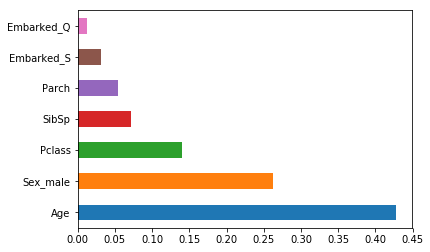

In [7]:
# Split data into train and test
test_size=0.20
random_state=100
X_train,X_test,y_train,y_test,X,y = split(target,df,test_size,random_state)

# Train the model
algo ='RF'   #'SV'    # 2 'LR'  #1 'RF' # 'SV'  #'NB'  #'LR' # 'RF'
X_train,y_train,model = train_model(X_train,X_test,y_train,y_test,X,y,algo,df)

if(algo == 'RF'):    
    feature_importance(X,model)


In [8]:
# Save model
save_model(models_path,model,algo)

if(algo == 'SV'):
    # Predict the results
    pred,conf_matrix,clas_report,acc_score= predict_results(model,X_test,y_test)
else:
    # Predict the results
    print('came inside else:\n')
    pred,pred_proba,conf_matrix,clas_report,acc_score= predict_results(model,X_test,y_test)
    
# Confusion Matrix
print('Confusion Matrix : \n ',conf_matrix)

# Classification Report
print(' \n Classification Report : \n ',clas_report)

# Accuracy
print(' \n Accuracy : \n ',acc_score*100)


came inside else:

Confusion Matrix : 
  [[47  7]
 [21 24]]
 
 Classification Report : 
               precision    recall  f1-score   support

          0       0.69      0.87      0.77        54
          1       0.77      0.53      0.63        45

avg / total       0.73      0.72      0.71        99

 
 Accuracy : 
  71.71717171717171


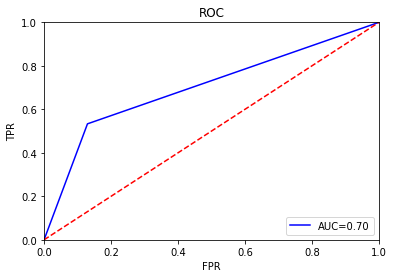

<module 'matplotlib.pyplot' from 'C:\\Users\\sunitha G\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
roc_curve_plot(y_test,pred)

In [10]:
# working one, now working for all.
def decile_analysis(decile_df,algo):    
    base_response_rate = np.round(100*decile_df[decile_df.y_true==1].shape[0]/decile_df.shape[0],decimals=2)
    print('base_response_rate : \n',base_response_rate)
    decile_df.sort_values(by='y_prob',inplace = True,ascending = False)
    decile_df.reset_index(inplace = True)
#     if(algo != 'SV'):
#         decile_df.sort_values(by='y_prob',inplace = True,ascending = False)
#         decile_df.reset_index(inplace = True)
#         print(' after reset index decile_df: \n',decile_df,decile_df.shape)
    decile_df['decile'] = np.nan
    d =int(np.ceil(decile_df.shape[0]/10))
    start = 0
    end = d
    for i in range(10):
        decile_df.loc[start:end,['decile']] = i+1
        start = start +d
        end = end +d
    qq = pd.crosstab(decile_df['decile'],decile_df['y_true'])
    print('qq after cross tab:\n',qq)
    qq.columns = ['zero','one']
    print('qq: \n',qq)       
    print(' before min_prob: \n',qq,qq.shape)
    qq['min_prob'] = decile_df.groupby(by=['decile']).min()['y_prob']
    qq['max_prob'] = decile_df.groupby(by=['decile']).max()['y_prob']
    qq['count'] = decile_df.groupby(by=['decile']).count()['y_prob']
    qq['gain'] = np.round(100*qq['one']/qq['one'].sum(),decimals=2)
    qq['cum_gain'] = np.cumsum(qq['gain'])
    qq['penetration'] = (qq['one']/qq['count'])*100
    print('final qq: \n',qq) 
    return qq

In [11]:
df_decile = pd.DataFrame()
df_decile['y_true'] = y_test
df_decile['y_prob'] = pred_proba
df_decile['y_pred'] = pred
df_decile['decile'] = pd.cut(df_decile['y_prob'],10,labels=range(10,0,-1))
# if(algo != 'SV'):
#     df_decile['y_prob'] = pred_proba
#     df_decile['decile'] = pd.cut(df_decile['y_prob'],10,labels=range(10,0,-1))


In [12]:
decile_analysis(df_decile,algo)

base_response_rate : 
 45.45
qq after cross tab:
 y_true   0   1
decile        
1.0      2   8
2.0      0  10
3.0      4   6
4.0      7   3
5.0      8   2
6.0      7   3
7.0      7   3
8.0      5   5
9.0     10   0
10.0     4   5
qq: 
         zero  one
decile           
1.0        2    8
2.0        0   10
3.0        4    6
4.0        7    3
5.0        8    2
6.0        7    3
7.0        7    3
8.0        5    5
9.0       10    0
10.0       4    5
 before min_prob: 
         zero  one
decile           
1.0        2    8
2.0        0   10
3.0        4    6
4.0        7    3
5.0        8    2
6.0        7    3
7.0        7    3
8.0        5    5
9.0       10    0
10.0       4    5 (10, 2)
final qq: 
         zero  one  min_prob  max_prob  count   gain  cum_gain  penetration
decile                                                                    
1.0        2    8  0.950000  0.990000     10  17.78     17.78    80.000000
2.0        0   10  0.830000  0.935833     10  22.22     40.00   100

zero  one  min_prob  max_prob  count   gain  cum_gain  penetration
decile                                                                    
1.0        2    8  0.950000  0.990000     10  17.78     17.78    80.000000
2.0        0   10  0.830000  0.935833     10  22.22     40.00   100.000000
3.0        4    6  0.592833  0.830000     10  13.33     53.33    60.000000
4.0        7    3  0.359800  0.533333     10   6.67     60.00    30.000000
5.0        8    2  0.260000  0.350000     10   4.44     64.44    20.000000
6.0        7    3  0.160000  0.234444     10   6.67     71.11    30.000000
7.0        7    3  0.107500  0.156944     10   6.67     77.78    30.000000
8.0        5    5  0.040000  0.090000     10  11.11     88.89    50.000000
9.0       10    0  0.014167  0.040000     10   0.00     88.89     0.000000
10.0       4    5  0.000000  0.010000      9  11.11    100.00    55.555556